# <div style="text-align: center">18.335/6.337 Problem Set 4 - Least Squares and GMRES</div>
## <div style="text-align: center">Solution</div>
### <div style="text-align: center">Created by Wonseok Shin</div>

$\newcommand{\Cmat}[2]{\mathbb{C}^{#1\times#2}}\newcommand{\Cvec}[1]{\mathbb{C}^{#1}}\newcommand{\Rmat}[2]{\mathbb{R}^{#1\times#2}}\newcommand{\Rvec}[1]{\mathbb{R}^{#1}}\newcommand{\null}{\mathrm{null}}\newcommand{\range}{\mathrm{range}}\newcommand{\rank}{\mathrm{rank}}\newcommand{\nullity}{\mathrm{nullity}}\newcommand{\sign}{\mathrm{sign}}\newcommand{\norm}[1]{\left\|#1\right\|}\newcommand{\abs}[1]{\left|#1\right|}\newcommand{\epsmach}{\epsilon_\mathrm{machine}}\newcommand{\log}{\mathrm{log}}\newcommand{\tanh}{\mathrm{tanh}}\newcommand{\l}{\lambda}\newcommand{\d}{\delta}$

## Problem 1.  Algorithms for least squares problems [3 pts]

(Partly taken from Exercise 11.3 of T&B)

In this problem, we will implement the various algorithms to solve least squares problems.  The least squares problem we would like to solve is the polynomial fitting problem. 

### Assignment 1.1.  Vandermonde matrix [0.5 pts]

As discussed in class, we need a Vandermonde matrix for polynomial fitting.  Complete `vander` below that returns the $m\times n$ Vandermonde matrix for a vector $x$ of $m$ measurement points and polynomial degree $n-1$.

In [1]:
function vander(x, n)
    m = length(x)
    V = similar(x, m, n)
    
    V[:,1] = 1
    for j = 2:n
        V[:,j] .= x .* @view(V[:,j-1])
    end
    
    return V
end

vander (generic function with 1 method)

### Validation of your implementation

Use the following code block to validate your implementation of `vander`.

In [2]:
m = 10
x = rand(m)

V = [ones(m) x x.^2 x.^3 x.^4]
n = size(V,2)

println("Vandermonde? $(V ≈ vander(x, n))")

Vandermonde? true


### Assignment 1.2.  Forward and back substitution [0.5 pts]

The algorithms for solving least squares problems often require solving triangular systems of linear equations.  Triangular systems of linear equations are solved by forward or back substitution depending on whether the matrix is upper or lower triangular.  Complete `subs!` below that solves a triangular system of linear equations $T x = b$.  The back substitution algorithm is described in Alg. 17.1 of T&B, and the forward substitution algorithm is not much different.

The function takes two mandatory input arguments `T` and `b`:
- `T` stores an upper or lower triangular matrix, and
- `b` is the right-hand-side vector.

In addition, the function takes an optional argument `isfwd`.  If `isfwd = true`, use forward substitution for the upper triangular portion of `T`; otherwise, use back substitution for the lower triangular portion of `T`.

After execution of `subs!(T, b, isfwd)`,
- `T` remains the same as before, and
- `b` stores the solutino $x$ of $T x = b$.

In [3]:
function subs!(T, b, isfwd)
    m = length(b)

    x = b  # reference copy
    ivec = isfwd ? (1:m) : (m:-1:1)
    
    i = 1
    r = ivec[i]
    x[r] /= T[r,r]
    
    for i = 2:m
        r = ivec[i]
        for j = i-1:-1:1
            c = ivec[j]
            x[r] -= T[r,c] * x[c]
        end
        x[r] /= T[r,r]
    end
    
    return nothing
end

subs! (generic function with 1 method)

### Validation of your implementation

Use the following code block to validate your implementation of `subs!`.

In [4]:
m = 5
b = rand(Complex128, m)

# Forward substitution
L = tril(rand(Complex128, m, m))
x = copy(b)
subs!(L, x, true)
println("x ≈ L\\b?  $(x ≈ L\b)")


# Back substitution
U = triu(rand(Complex128, m, m))
x = copy(b)
subs!(U, x, false)
println("x ≈ U\\b?  $(x ≈ U\b)")

x ≈ L\b?  true
x ≈ U\b?  true


### Assignment 1.3.  Least squares solution [2 pts]

Complete `solve_lsp` that returns the solution $x$ of the least squares problem specified by a full-rank skinny matrix $A \in \Cmat{m}{n}$ and a column vector $b \in \Cvec{m}$ using a specific algorithm.

The function takes three arguments `A`, `b`, and `alg`:

- `A` stores the matrix $A$,
- `b` stores the vector $b$, and
- `alg` is a string specifying the algorithm to use.

The seven possible string values of `alg` and the corresponding algorithms to use are as follows:

- `"nrm"`: least squares via a normal equation (Alg. 11.1)
- `"clgs"`: least squares via QR factorization using CLGS (Alg. 11.2)
- `"mgs"`: least squares via QR factorization using MGS or MGSC (your choice) (Alg. 11.2)
- `"hh"`: least squares via QR factorization using Householder triangularization (Alg. 11.2)
- `"qr"`: least squares via QR factorization using Julia's `qr` function (Alg. 11.2)
- `"svd"`: least squares via SVD (Alg. 11.3)
- `"ldiv"`: least squares via Julia's backslash operator `\`

After executing `solve_lsa(A, b, alg)`, 

- `A` and `b` remain the same as before, and 
- the solution vector `x` is returned.

The function will need to use `subs!` and many other helper functions written in the previous problem sets.  You are welcome to copy and paste either your or posted solutions' version of those functions in this notebook.  Alternatively, if you don't want to clutter this notebook, you can put those function in a separate Julia file named `lsp_helpers.jl` and include the file (see the code block below).

In [5]:
include("lsp_helpers.jl")  # uncomment to include file

function solve_lsp(A, b, alg)
    m, n = size(A)

    if alg == "nrm"  # normal equation
        AA, x = A'A, A'b
        U = chol(AA)
        subs!(U', x, true)
        subs!(U, x, false)
    elseif alg == "clgs"  # QR by CLGS
        R = similar(A, n, n)
        Q = copy(A)
        clgs!(Q, R)
        x = Q'b
        subs!(R, x, false)
    elseif alg == "mgs"  # QR by MGS or MGSC
        R = similar(A, n, n)
        Q = copy(A)
        mgsc!(Q, R)  # A is Q
        x = Q'b
        # Replace the above line with the following commented lines for Bonus Problem.
#         x = similar(b, n)
#         v = copy(b)
#         for j = 1:n
#             x[j] = ortho_against!(v, v, @view(Q[:,j]))
#         end
        subs!(R, x, false)
    elseif alg == "hh"  # QR by Householder
        V = similar(A)
        R = copy(A)
        house!(V, R)
        x = copy(b)
        applyQhouse!(V, x, true)
        x = x[1:n]
        subs!(R, x, false)
    elseif alg == "qr"  # QR by Julia's qr
        Q, R = qr(A)
        x = (Q'b)[1:n]
        subs!(R, x, false)
    elseif alg == "svd"  # SVD
        U, σ, V = svd(A)
        x = V * ((U'b)./σ)
    elseif alg == "ldiv"  # backslash operator
        x = A\b
    else
        throw(ArgumentError("alg = $alg is invalid."))
    end
    
    return x
end

solve_lsp (generic function with 1 method)

### Validation of your implementation

Use the following code block to validate your implementation of `lsp_solve`.  It fits a degree-11 polynomial to $\cos(t)$ for $t \in \left[0, 1\right]$ using all the algorithms implemented in `lsp_solve` and plots the fitted curves.  It also displays the calculated polynomial coefficients and relative residual error of each algorithm.  See which algorithms produce loosely fitted results.

	nrm		clgs		mgs		hh		qr		svd		ldiv
-------------------------------------------------------------------------------------------------------------------
error	1.2205e-08	8.5318e-06	4.1837e-09	1.5053e-09	1.5053e-09	1.5053e-09	1.5053e-09	
-------------------------------------------------------------------------------------------------------------------
coeff	1.0000e+00	1.0000e+00	1.0000e+00	1.0000e+00	1.0000e+00	1.0000e+00	1.0000e+00	
	4.1801e-06	-2.3626e-03	9.1021e-07	-4.2274e-07	-4.2274e-07	-4.2274e-07	-4.2274e-07	
	-8.0001e+00	-7.9350e+00	-8.0000e+00	-8.0000e+00	-8.0000e+00	-8.0000e+00	-8.0000e+00	
	2.1025e-03	-7.1040e-01	4.1970e-04	-3.1876e-04	-3.1876e-04	-3.1876e-04	-3.1876e-04	
	1.0651e+01	1.4686e+01	1.0664e+01	1.0669e+01	1.0669e+01	1.0669e+01	1.0669e+01	
	6.7010e-02	-1.3234e+01	1.1713e-02	-1.3820e-02	-1.3820e-02	-1.3820e-02	-1.3820e-02	
	-5.8731e+00	2.1103e+01	-5.7195e+00	-5.6471e+00	-5.6471e+00	-5.6471e+00	-5.6471e+00	
	3.3371e-01	-3.3855e+01	5.7343e-02	-7.5316e-02	-7.5316e-02	-7.5

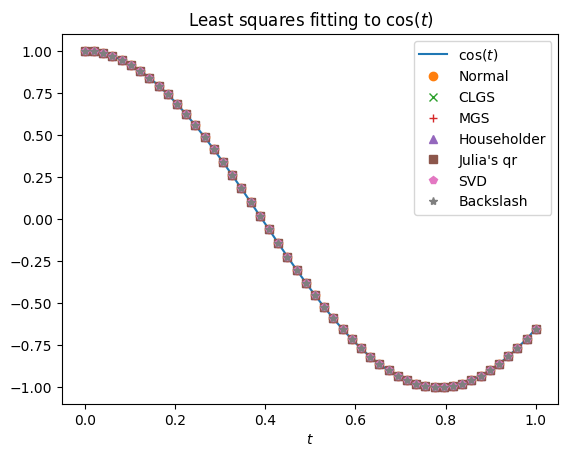

-01	6.0321e-03	6.0321e-03	6.0321e-03	6.0321e-03	
	-5.1841e-01	1.8322e+00	-4.2240e-01	-3.7424e-01	-3.7424e-01	-3.7424e-01	-3.7424e-01	
	1.1386e-01	2.9609e-02	9.6732e-02	8.8041e-02	8.8041e-02	8.8041e-02	8.8041e-02	


In [6]:
using PyPlot

# Construct the least squares problem.
m, n = 50, 12

t = linspace(0, 1, m);
A = vander(t, n)
b = cos.(4*t);

# Solve the least squares problem by various algorithms.
x_nrm = solve_lsp(A, b, "nrm")
x_clgs = solve_lsp(A, b, "clgs")
x_mgs = solve_lsp(A, b, "mgs")
x_hh = solve_lsp(A, b, "hh")
x_qr = solve_lsp(A, b, "qr")
x_svd = solve_lsp(A, b, "svd")
x_ldiv = solve_lsp(A, b, "ldiv")

# Plot the fitted curves.
plot(t, b, "-", 
    t, A*x_nrm, "o", 
    t, A*x_clgs, "x", 
    t, A*x_mgs, "+", 
    t, A*x_hh, "^", 
    t, A*x_qr, "s", 
    t, A*x_svd, "p", 
    t, A*x_ldiv, "*")

legend([L"\cos(t)", "Normal", "CLGS", "MGS", "Householder", "Julia's qr", "SVD", "Backslash"])
title(L"Least squares fitting to $\cos(t)$")
xlabel(L"t")

# Prepare the solutions to print.
X = [x_nrm x_clgs x_mgs x_hh x_qr x_ldiv x_svd]

# Prepare the errors to print.
norm_b = norm(b)
R = b .- A*X
relerr = sqrt.(sum(abs2, R, 1)) ./ norm_b

# Print the errors and solutions.
println("\tnrm\t\tclgs\t\tmgs\t\thh\t\tqr\t\tsvd\t\tldiv")
for i = 1:115; print("-"); end; println()

print("error\t")
for j = 1:7
    @printf "%1.4e\t" relerr[j]
end
println()

for i = 1:115; print("-"); end; println()

print("coeff")
for i = 1:n
    print("\t")
    for j = 1:7
        @printf "%1.4e\t" X[i,j]
    end
    println()
end

## Problem 2.  Point with the least root-mean-square distance from affine subspaces [4 pts]

For given $A \in \Cmat{m}{n}$ and $p \in \Cvec{m}$, consider the following set of points:

$$
F = \{p + A x \mid x \in \Cvec{n} \}
$$

$F$ is called an affine subspace of $\Cvec{m}$, and it is nothing but a subspace $\range(A)$ translated by some vector $p$.  Unlike subspaces, affine subspaces do not necessarily contain the origin.  For example, a plane away from the origin is an affine subspace in 3D.

Like you measure the distance from a point to a plane in 3D, you can measure the distance from a point to an affine subspace.  The distance from $z \in \Cvec{m}$ to an affine subspace $F$ is defined by the distance between $z$ and the closest point in $F$, i.e.,

$$
d = \min_{f \in F} \norm{z - f},
$$

where $\norm{\cdot}$ is the 2-norm.

Now, suppose that we have $k$ affine subspaces $F_1, \ldots, F_k$ of $\Cvec{m}$ defined by points $p_1, \ldots, p_k \in \Cvec{m}$ and matrices $A_1, \ldots, A_k$.  (all the $A_i$'s have $m$ rows, but they do not necessarily have the same number of columns, i.e., $A_1 \in \Cmat{m}{n_1}, \ldots, A_k \in \Cmat{m}{n_k}$.)  The goal of this problem is to find the point $z$ that minimizes the root-mean-square (RMS) distance  to these affine spaces.  In other words, we want to find $z$ minimizing

$$
d_\mathrm{rms} = \sqrt{\frac{1}{k}\sum_{i=1}^k d_i^2},
$$

where $d_i = \min_{f \in F_i} \norm{z - f}$.

**(a) [2 pts]** For given $p_1, \ldots, p_k$ and $A_1, \ldots, A_k$, explain how to find such $z$ and corresponding $d_\mathrm{rms}$ by solving a least squares problem.  For simplicity, assume that the columns of each $A_i$ are orthonormal.

***Solution.***

We can derive the closed-form formula for each $d_i$.  For given $z$, 

$$
d_i = \min_{f \in F_i} \norm{z - f} = \min_{x \in \Cvec{n}} \norm{(z - p_i) - A_i x},
$$

where $x$ minimizing the last expression is the solution to a least squares problem and therefore is $x = (A_i^* A_i)^{-1} A_i^* (z-p_i) = A_i^* (z-p_i)$.  Hence,

$$
d_i = \norm{(z-p_i) - A_i A_i^* (z-p_i)} = \norm{(I - A_i A_i^*) (z-p_i)}.
$$

This makes sense geometrically.  $A_i A_i^*$ is the orthogonal projector *onto* $\range(A_i)$, so $I - A_i A_i^*$, which is the complementary projector of $A_i A_i^*$, is the orthogonal projector *along* $\range(A_i)$.  Because $z-p_i$ is the vector connecting $z$ and a point $p_i$ on the affine space, $(I - A_i A_i^*) (z-p_i)$ is the component of $z-p_i$ perpendicular to the affine space, and thus its length is the distance from $z$ to the affine space.

Using the above formula for $d_i$, we can write

$$
k^2 d_\mathrm{rms} = \sum_{i=1}^k d_i^2 = \norm{\left[
\begin{array}{c}
 (I - A_1 A_1^*) (z-p_1) \\
 \vdots  \\
 (I - A_k A_k^*) (z-p_k) \\
\end{array}
\right]}^2 =
\norm{\left[
\begin{array}{c}
 I - A_1 A_1^* \\
 \vdots  \\
 I - A_k A_k^* \\
\end{array}
\right] z - \left[
\begin{array}{c}
 (I - A_1 A_1^*) p_1 \\
 \vdots  \\
 (I - A_k A_k^*) p_k \\
\end{array}
\right]}^2.
$$

$z$ minimizing the last expression can be obtained by solving the least squares problem whose matrix $A$ and right-hand side vector $b$ are

$$
A = \left[
\begin{array}{c}
 I - A_1 A_1^* \\
 \vdots  \\
 I - A_k A_k^* \\
\end{array}
\right],\quad b = \left[
\begin{array}{c}
 (I - A_1 A_1^*) p_1 \\
 \vdots  \\
 (I - A_k A_k^*) p_k \\
\end{array}
\right],
$$

and the minimim $d_\mathrm{rms}$ can be easily obtained using this $z$.

**(b) [1 pt]** When does the matrix of your least squares problem in Part (a) become rank-deficient that you need to solve it via SVD?  Describe the condition in terms of $A_1, \ldots, A_k$.

***Solution.***

The matrix $A$ in the solution to Part (a) is skinny.  Therefore, it becomes rank-deficient when its nullspace has a nonzero vector as an element.

$A$ has $v \neq 0$ in its nullspace if and only if $(I - A_i A_i^*) v = 0$ for all $i = 1, \ldots, k$.  Therefore, $A$ becomes rank-deficient if and only if there is a nonzero vector shared by the nullspaces of all $I - A_i A_i^*$'s.

Note that $I - A_i A_i^*$ is an orthogonal projector *along* $\range(A_i)$, so its nullspace is nothing but $\range(A_i)$.  Therefore, we conclude that $A$ becomes rank-deficient if and only if there is a nonzero vector shared between $\range(A_i)$'s.

**(c) [1 pt]** Assuming the given $A_1, \ldots, A_k$ do not fall into the case described in Part (b), complete `pt_min_drms` below that takes an array of $p_i$'s and an array of $A_i$'s and returns $z$ and $d_\mathrm{rms}$.  You are welcome to use the backslash operator (`\`) for the least squares solution. 

Execute the subsequent code block to check if your function runs without errors.  (This is just to detect syntax errors.)

In [7]:
function pt_min_drms(p, A)
    # p[1], p[2], ... are pᵢ's, and A[1], A[2], ..., are Aᵢ's.
    
    k = length(p)
    assert(length(A) == k)
    m = size(A[1], 1)
    
    T = eltype(p[1])
    
    # Construct the matrix (Atot) and vector (btot) of the least squares problem.
    I = eye(T, m)
    Atot = Matrix{T}(k*m, m)
    btot = Vector{T}(k*m)
    for i = 1:k
        P = I - A[i]*A[i]'  # individual orthogonal projector

        ind0 = 1+(i-1)*m
        ind1 = i*m
        
        Atot[ind0:ind1, :] = P
        btot[ind0:ind1] = P * p[i]
    end
    
    # Find the d_rms-minimizing point z and the corresponding d_rms.
    z = Atot \ btot
    drms = norm(btot - Atot*z) / sqrt(k)
    
    return z, drms
end

pt_min_drms (generic function with 1 method)

In [8]:
using JLD
@load "pA.jld"

z, drms = pt_min_drms(p, A)

println("z = [")
for zi = z
    println("\t$zi")
end
println("]\n")
println("d_rms = $drms\n")

z = [
	0.42946161321334936 + 0.41552749863761124im
	0.528634090375491 + 0.4211799505562526im
	0.4699021253109107 + 0.4322522670737496im
	0.4918664675439409 + 0.5012237014956257im
]

d_rms = 0.5631677852242845



## Problem 3.  GMRES [3 pts]

In this problem, we will implement GMRES ourselves.  Throughout this problem, assume $A \in \Cmat{m}{m}$ is full-rank.

### Assignment 1.1.  `arnoldi!` [1 pt]

In Step $n$ of GMRES, the Arnoldi iteration orthogonalizes $A q_n$ against the already constructed $n$ Arnoldi vectors $q_1, \ldots, q_n$ to construct a new Arnoldi vector $q_{n+1}$.  

Complete `arnoldi!` below that performs a single Step $n$ of the Arnoldi iteration.  (You can perform the entire Arnoldi iteration by executing `arnoldi!` successively for $n = 1, 2, 3, ...$.)

Here are the descriptions of the four arguments of the function: `n`, `A`, `Q`, and `h`.

- `n` indicates that you are about to execute Step $n$ of the Arnoldi iteration.
- `A` is the $m\times m$ matrix that generates the Krylov subspace.
- `Q` is an $m\times (n_\max+1)$ matrix whose first $n$ ($\le n_\max$) columns are filled with the Arnoldi vectors $q_1, \ldots, q_n$.
- `h` is an empty vector with $n_\max+1$ entries.

After execution of the function,

- `n` and `A` remain the same,
- the $(n+1)$th column of `Q` stores a newly constructed Arnoldi vector $q_{n+1}$, and
- `h` stores the $n$th column of $\tilde{H}_n$ of the Arnoldi iteration; in other words, `h[i]` is the $q_i$-coordinate of $A q_n$ for $i = 1, \ldots, n+1$, and the remaining entries of `h` are unused.
  
In the size $m\times (n_\max+1)$ of `Q`, $n_\max$ ($\le m$) is the maximum number of the Arnoldi iteration steps you intend to perform.  You allocate large enough memory for `Q` to perform $n_\max$ steps of the Arnoldi iteration.  The Arnoldi iteration constructs $q_{n_\max+1}$ at Step $n_\max$.  Hence, to store $q_1, \ldots, q_{n_\max}$ and $q_{n_\max+1}$, you need to allocate an $m\times (n_\max+1)$, rather than $m\times n_\max$, matrix for `Q`.

If $n_\max = m$, the Arnoldi vector $q_{n_\max+1}$ constructed in the last Step $n_\max$ must be zero, because you already have $m$ orthonormal Arnoldi vectors.  However, $q_{n_\max+1}$ constructed by the Gram–Schmidt orthogonalizaiton inside the Arnoldi iteration is not exactly zero due to rounding errors.  Therefore, you will need to force $q_{n_\max+1} = 0$ in this case.

In [9]:
function arnoldi!(n, A, Q, h)
    m = size(A, 1)
    qₙ = @view Q[:,n]
    v = @view Q[:,n+1]

    v .= A*qₙ
    lv = norm(v)

    for j = 1:n
        qⱼ = @view Q[:,j]
        h[j] = qⱼ⋅v
        v .-= h[j]*qⱼ
    end
    
    if n < m
        h[n+1] = norm(v)
        v ./= h[n+1]
    else
        h[n+1] = 0
        fill!(v, 0)
    end
    
    return nothing
end

arnoldi! (generic function with 1 method)

### Validation of your implementation

Validate your implementation of `arnoldi!` using the following code block.  It performs the Arnoldi iteration for the entire $m$ steps.  

In [10]:
m = 10
nmax = 10

A = rand(Complex128, m, m)
Q = zeros(Complex128, m, nmax+1)
H = zeros(Complex128, nmax+1, nmax)

b = rand(Complex128, m)
x₀ = rand(Complex128, m)
r₀ = b - A * x₀

ρ = norm(r₀)
q₁ = r₀ / ρ

Q[:,1] = q₁

for n = 1:nmax
    h = @view H[:,n]
    arnoldi!(n, A, Q, h)
end

println("Hₙ upper-Hessenberg?  $(H == triu(H, -1))")
println("Qₙ* Qₙ ≈ I?  $(Q[:,1:nmax]' * Q[:,1:nmax] ≈ eye(nmax))")
println("AQₙ ≈ Qₙ₊₁H̃ₙ?  $(A*Q[:,1:nmax] ≈ Q*H)")

Hₙ upper-Hessenberg?  true
Qₙ* Qₙ ≈ I?  true
AQₙ ≈ Qₙ₊₁H̃ₙ?  true


### Assignment 1.2.  `gmres!` [2 pts]

Now, using `arnoldi!` as well as `subs!` written in Prob. 1 and `givens_h!` written in the previous problem set, complete `gmres!` that solves a system of linear equations $A x = b$ by GMRES.  The last validation code block already implements the heart of the GMRES iteration, so it should be a good starting point for full-fledged implementation.  For this assignment, copy the code for `givens_h!` from the previous problem set.  You can use either your version or the version in the posted solution.

The function `gmres` takes five arguments `A`, `b`, `x`, `tol`, and `nmax`:

- `A` and `b` are $A \in \Cmat{m}{m}$ and $b \in \Cvec{m}$ of the equation $A x = b$.
- `x` is an initial guess $x_0$ of the solution.
- `tol` is the tolerance $\tau$ of the stopping criterion $\norm{r_n} / \norm{b} \le \tau$.  Its default value is $10^{-6}$.
- `nmax` is the maximum number $n_\max$ of iteration steps you allow in GMRES.  Theoretically, all Krylov subspace methods find the exact solution in at most $m$ steps in exact arithmetic, but in practice they don't finish even after $m$ steps in the presence of rounding errors if the matrix has an unfavorable eigenvalue spectrum.  `nmax` is needed to terminate iteration in such hopless cases.

Execution of the function changes only `x` among all arguments.  After execution of the function, `x` stores either a converged solution satisfying the stopping criterion $\norm{r_n} / \norm{b} \le \tau$, or an unconverged solution obtained as a result of premature termination by reaching `nmax` steps.

Additionally, `gmres!` returns two more parameters:

- `n`, the number of iteration steps taken until reaching `x` (i.e., $n$ of $x_n$ stored in `x`), and
- `relres`, a vector with $n_\max+1$ entries whose first $n+1$ entries store the relative residual errors $\frac{\norm{r_0}}{\norm{b}}, \ldots, \frac{\norm{r_n}}{\norm{b}}$.

These two parameters are used to plot the convergence behavior.  Note that `relres[1]` is not $\frac{\norm{r_1}}{\norm{b}}$, but $\frac{\norm{r_0}}{\norm{b}}$.

In [11]:
function givens_h!(k, c, s, h)
    # Apply the previously constructed Givens rotations to h.
    for i = 1:k-1
        x, y = h[i], h[i+1]
        h[i] = c[i]'*x + s[i]'*y
        h[i+1] = -s[i]*x + c[i]*y
    end

    # Construct a new Givens rotation to nullify the last entry of h.
    x, y = h[k], h[k+1]
    d = hypot(x, y)
    if d == 0  # rank-deficient case
        c[k] = 1
        s[k] = 0
    else
        c[k] = x / d
        s[k] = y / d
    
        # Nullify the last entry of h using the Givens rotation.
        h[k] = c[k]'*x + s[k]'*y
        h[k+1] = 0
    end
    
    return nothing
end

givens_h! (generic function with 1 method)

In [12]:
function gmres!(A, b, x, tol=1e-6, nmax=length(b))
    m = length(b)

    r₀ = b - A * x
    β = norm(b)
    ρ = norm(r₀)
    ρe₁ = similar(A, nmax+1); ρe₁ .= 0
    ρe₁[1] = ρ

    Q = similar(A, m, nmax+1); Q .= 0  # need space for one more column qₙ₊₁ constructed by Arnoldi
    R = similar(A, nmax+1, nmax); R .= 0
    G = similar(A, 2, 2)  # placeholder for Givens rotation    
    c = similar(A, nmax)
    s = similar(A, nmax)
    relres = zeros(nmax+1)  # one more space to store ‖r₀‖ / ‖b‖

    Q[:,1] = r₀ / ρ
    r2b = ρ / β
    relres[1] = r2b
    n = 0
    while n < nmax && r2b > tol
        n += 1
        # Construct one more columns of Q and H̃.
        h = @view R[:,n]
        arnoldi!(n, A, Q, h)

        # QR-factorize H̃ into U R using the Givens rotation.
        givens_h!(n, c, s, h)

        # Apply Uₙ* to ρe₁.
        z₁, z₂ = ρe₁[n], ρe₁[n+1]
        ρe₁[n] = c[n]'*z₁ + s[n]'*z₂
        ρe₁[n+1] = -s[n]*z₁ + c[n]*z₂

        r2b = abs(ρe₁[n+1]) / β  # ρe₁[n+1] = σₙ and |σₙ| = ‖rₙ‖
        relres[n+1] = r2b
    end

    subs!((@view R[1:n,1:n]), (@view ρe₁[1:n]), false)
    x .+= (@view Q[:,1:n]) * (@view ρe₁[1:n])

    return n, relres
end

gmres! (generic function with 3 methods)

### Validation of your implementation

The following code block solves $A x = b$ with your `gmres!` for benchmark $A$ and $b$, and compares its convergence curves for $\tau$- and $n_\max$-terminated cases with the reference convergence curve obtained by a separate GMRES implementation.

If your `gmres!` is implemented correctly, the two sets of convergence data points (`relres1` and `relres2`) obtained by your `gmres!` must lie on the reference curve.  In addition, the convergence data points for the $n_\max$-terminated case (`relres2`) must stop at $n = 30$.

Validate your implementation of `gmres!` using this code block.

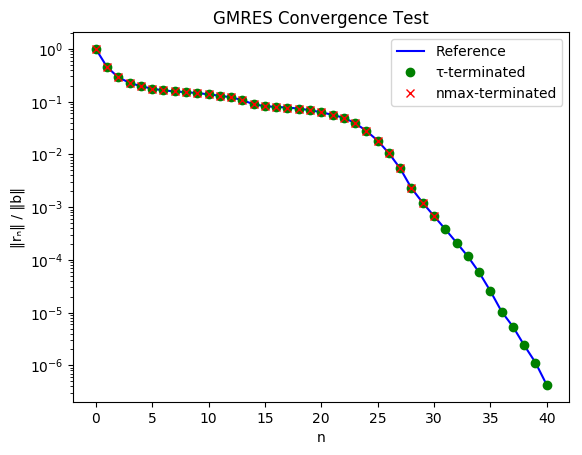

PyObject <matplotlib.legend.Legend object at 0x136c74358>

In [13]:
using JLD

# Load A, b, and reference relres.
@load "bench_gmres.jld"
n = findlast(relres .> 0) - 1

m = size(b)

tol = 1e-6
x = zeros(Complex128, m)
n1, relres1 = gmres!(A, b, x, tol)

nmax = 30
x = zeros(Complex128, m)
n2, relres2 = gmres!(A, b, x, tol, nmax)

using PyPlot
semilogy(0:n, relres[1:n+1], "b-", 0:n1, relres1[1:n1+1], "go", 0:n2, relres2[1:n2+1], "rx")
title("GMRES Convergence Test")
xlabel("n")
ylabel("‖rₙ‖ / ‖b‖")
legend(["Reference", "τ-terminated", "nmax-terminated"], loc="upper right")

## Bonus Problem.  Solution to least squares problems via MGS [2 pts]

In Prob. 1, you might have noticed that `alg = "mgs"` produces a poorer least squares solution than `alg = "hh"` or `alg = "qr"`.  In fact, there is a way to use MGS (or MGSC) to get an equally accurate solution.

**(a) [1 pt]**  When solving a least squares problem $\min_{x} \norm{b - A x}_2$ via QR factorization using MGS, we calculate the reduced QR factorization $A = \hat{Q} \hat{R}$ and then construct a linear system $\hat{R} x = \hat{Q}^* b$.  What is done poorly here is not the factorization, but the evaluation of $\hat{Q}^* b$.  Devise a way to perform $\hat{Q}^* b$ better.  (Hint: can you do it "MGS" way?)

***Solution.***

From the least squares problem, we construct an orthogonal projector $P = \hat{Q} \hat{Q}^*$ and construct a linear system $\hat{Q} \hat{R} x = A x = P b = \hat{Q} (\hat{Q}^* b)$, from which we get $\hat{R} x = \hat{Q}^* b$.  Here, the entries of the $j$th column of $\hat{R}$ are the coefficients of the linear combination of $q_i$'s to form $a_j$.  Similarly, the entries of the vector $\hat{Q}^* b$ are the coefficients of the linear combination of $q_i$'s to form $b$.  For consistency, these two sets of coefficients must be calculated in the same manner.  Let's see if that is the case.

When the QR factorization is performed by MGS(C), the entries of the $j$th column of $\hat{R}$ are constructed as $q_i^* v$ ($v$ keeps changing) that appears in the MGS procedure $v \leftarrow v - (q_i^* v) q_i$ with the initial $v = a_j$.  In contrast, the entries of the vector $\hat{Q}^* b$ are constructed as $q_i^* b$ ($b$ remains the same) that appears in the CLGS procedure $v \leftarrow v - (q_i^* b) q_i$.  Therefore, the two sets of coefficients are not constructed in the same manner, and hence leading to inconsistency.

Therefore, for consistency, we have to evaluate the entries of the vector $\hat{Q}^* b$ as $q_i^* v$ while updating $v$ as $v \leftarrow v - (q_i^* v) q_i$ with the initial $v = b$.

**(b) [1 pt]** Update the `alg = "mgs"` portion of `solve_lsp` in Assignment 1.3 using your idea discovered in Part (a) and evaluate the validation code block.  Check if you get a better solution for `alg = "mgs"`.